In [60]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance


Read in data

In [61]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [62]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

Define functions for notebook

100%|██████████| 30/30 [00:01<00:00, 27.34it/s]


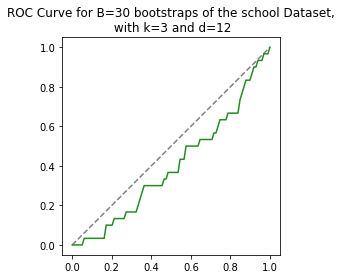

Total area (above and below y=x): 0.0962758902152842 for k=3


In [64]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 30
d = 12
k = 3

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset,\n with k={k} and d={d}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [65]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [66]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

Create ``similarity matrix $U$''  matrix from the obs and B bootstraps to estimate `in_cov_friends_symm`

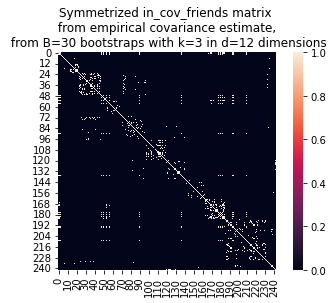

In [67]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

plt.plot(figsize = (6,6))
sns.heatmap(in_cov_friends_symm, square=True)
plt.title(f"Symmetrized in_cov_friends matrix \n from empirical covariance estimate, \n from B={B} bootstraps with k={k} in d={d} dimensions")
plt.savefig(f"figs/friends_mat_B{B}_k{k}_d{d}_EmpiricalCov.png", facecolor='w', bbox_inches='tight')

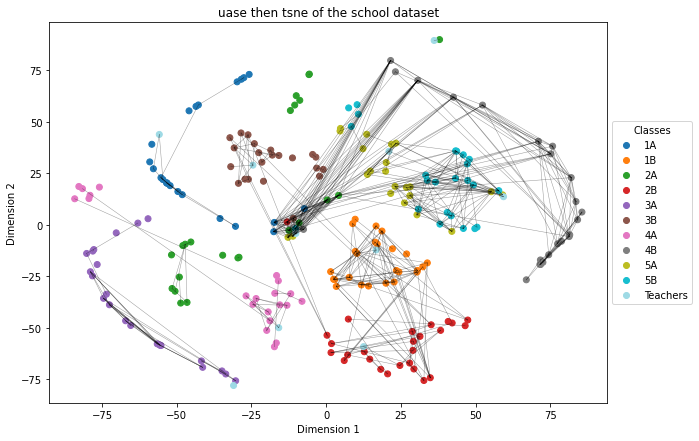

In [68]:
# tsne this embedding
perp_val = 30
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
yhat_tsne = tsne.fit_transform(yhat)


yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = np.tile(node_labels, B+1)

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Draw lines between connected nodes based on the adjacency matrix
for i in range(len(yhat_tsne_df0)):
    for j in range(i + 1, len(yhat_tsne_df0)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax1.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                     [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                     'k-', lw=0.5,alpha=0.4)  # Draw a line between them


# # Add legend for classes - 0 to 10 labels
# plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels = scatter.legend_elements()
# Invert the label_dict to map integers back to class names
label_dict_inv = {v: k for k, v in label_dict.items()}  
# Convert the labels back to their integer form, handling LaTeX formatting
mapped_labels = []
for label in labels:
    # Extract the numeric part using regex
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))  # Extract the integer from the label
        mapped_labels.append(label_dict_inv[numeric_label])  # Map to class name using the inverted dictionary
# Update the legend with the mapped labels
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

/tmp/ipykernel_92591/1152085316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])


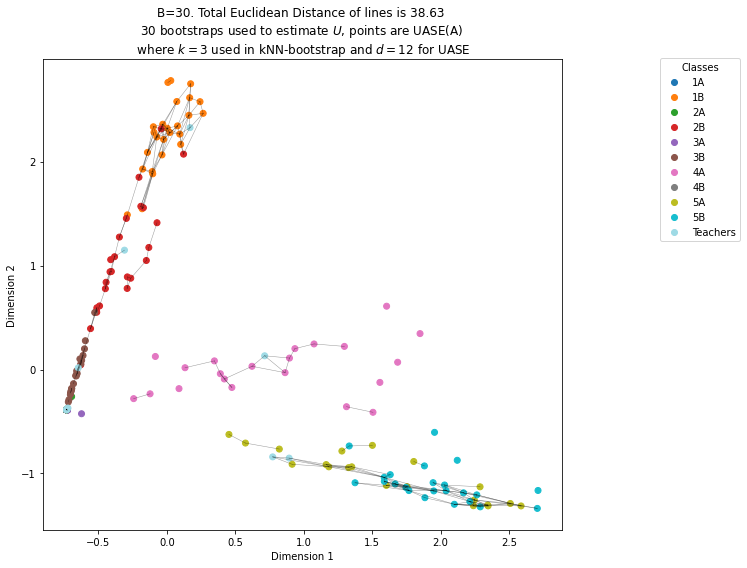

In [69]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8,8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Ensure matrix dimensions match, and avoid accessing out-of-bounds indices
num_nodes = len(Aobs_yadf)
if in_cov_friends_symm.shape != (num_nodes, num_nodes):
    raise ValueError(f"Expected in_cov_friends_symm to have dimensions ({num_nodes}, {num_nodes}), but got {in_cov_friends_symm.shape}.")

# Draw lines between connected nodes based on the adjacency matrix
# And calculate the total euclidean distance that the lines connecting the nodes in the d=2 space of A from UASE
total_distance = 0
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([Aobs_yadf["Dimension_1"].iloc[i], Aobs_yadf["Dimension_1"].iloc[j]], 
                    [Aobs_yadf["Dimension_2"].iloc[i], Aobs_yadf["Dimension_2"].iloc[j]], 
                    'k-', lw=0.5, alpha=0.4)  # Draw a line between them
            # Add this euclidean distance to the total_distance
            total_distance += np.linalg.norm(Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[i] - 
                                             Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[j])

# Round the total distance for clarity
total_distance = round(total_distance, 2)

# Set the title
ax.set_title(f"B={B}. Total Euclidean Distance of lines is {total_distance} \n{B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()


# Show the combined plot
plt.show()


In [70]:
Aobs_yadf = (yadf[yadf["Matrix"] == 0])

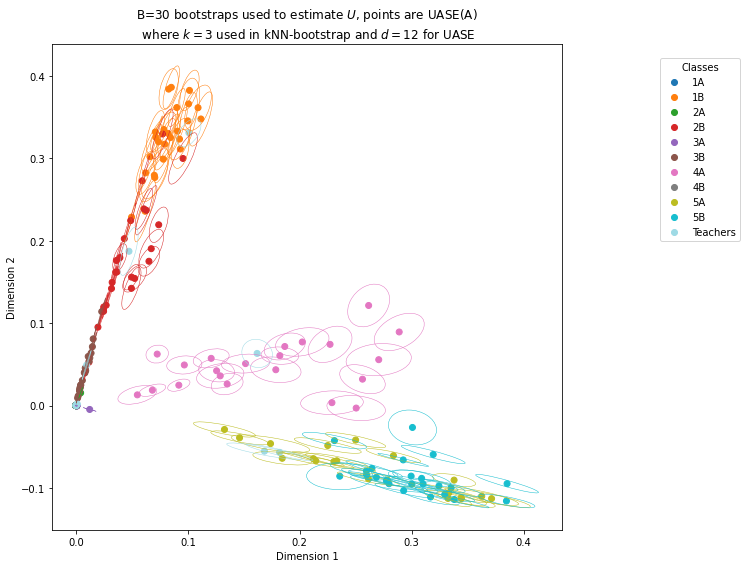

In [71]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 8))

# Aobs_yadf = (yadf[yadf["Matrix"] == 0])

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Retrieve the colors assigned by the scatter plot
scatter_colors = scatter.to_rgba(Aobs_yadf["tau"])

for i in range(len(Aobs_yadf)):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the covariance considering all d dimensions
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the color of the scatter point for the ellipse
    color = scatter_colors[i]

    # plot the covariance ellipse with the same color as the point
    plot_ellipse(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color=color, lw=0.5)

# Set the title
ax.set_title(f"B={B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the combined plot
plt.show()

### Different perplexity values

B=20 fixed and the $U$ matrix already calculated from the UASE

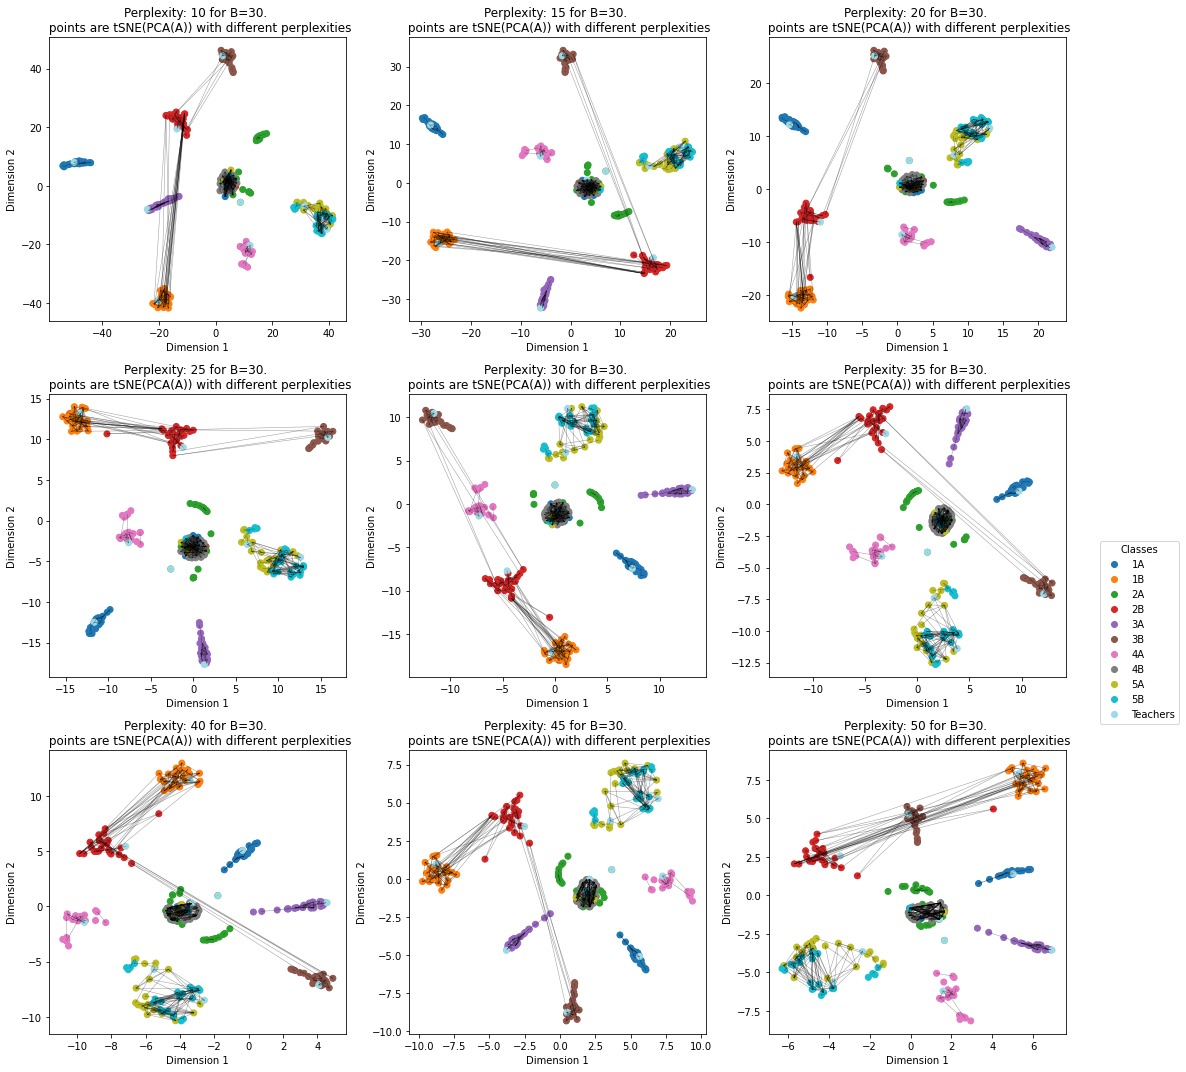

In [72]:
# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Embed Aobs (right embedding)
YA = single_spectral_Y(dense_adj, d=d)


# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the embedding of just the true adjacency matrix
    YA_tsne = tsne.fit_transform(YA)

    # Convert to DataFrame
    YA_tsne_df = pd.DataFrame(YA_tsne)
    YA_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(YA_tsne_df.shape[1])]
    YA_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(YA_tsne_df["Dimension_1"], YA_tsne_df["Dimension_2"], c=YA_tsne_df["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val} for B={B}. \n points are tSNE(PCA(A)) with different perplexities")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(YA_tsne_df)):
        for j in range(i + 1, len(YA_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([YA_tsne_df["Dimension_1"].iloc[i], YA_tsne_df["Dimension_1"].iloc[j]], 
                        [YA_tsne_df["Dimension_2"].iloc[i], YA_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA1_tsne_perplexity_B20_plot_tsne(PCA(A)).png", facecolor='white')

# Show the combined plot
plt.show()

### Fix perplexity and change B

100%|██████████| 50/50 [00:02<00:00, 21.70it/s]


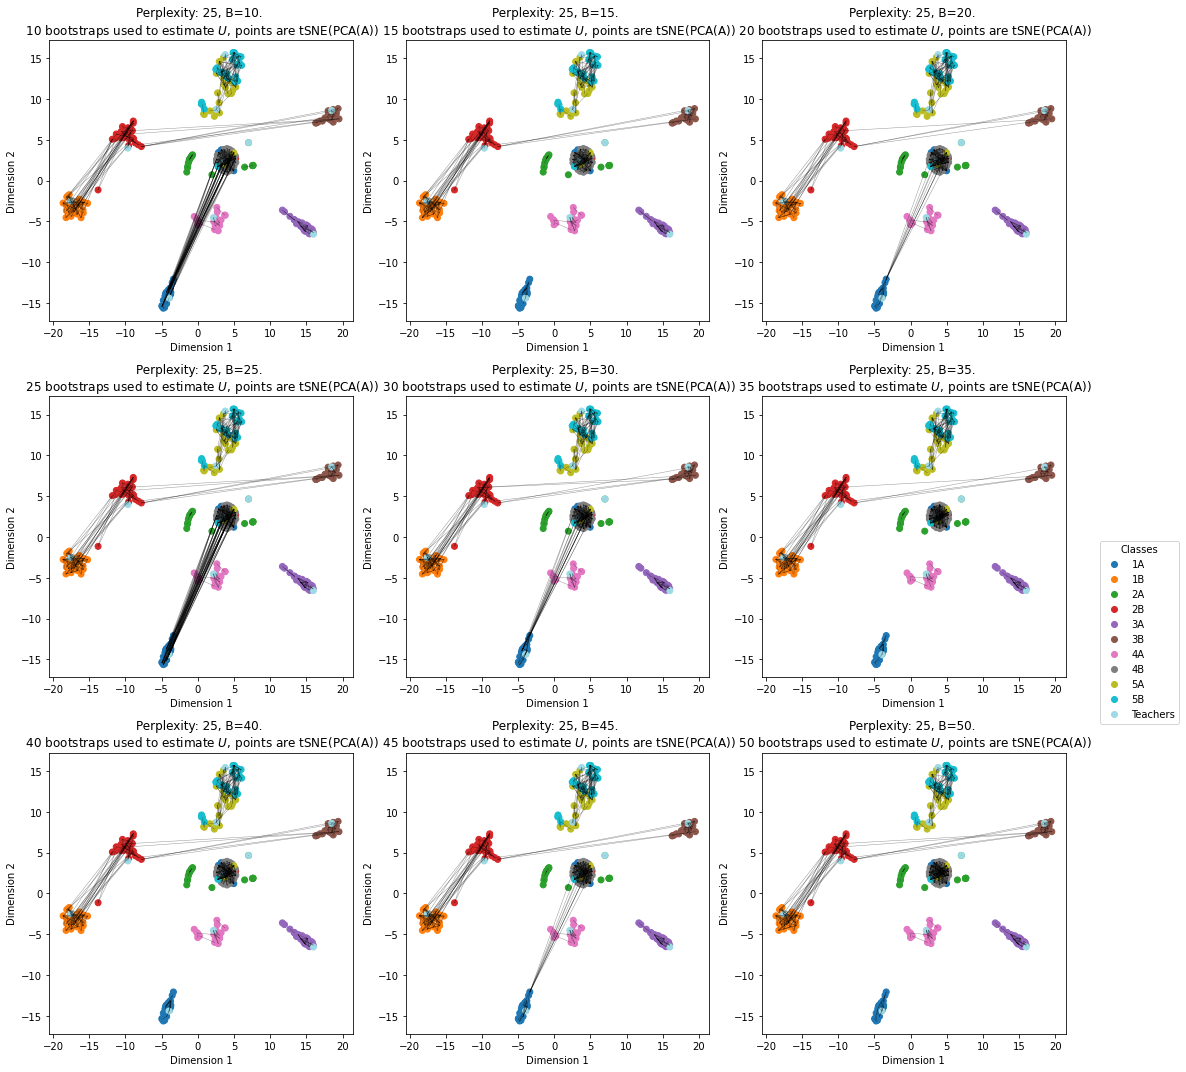

In [73]:
# Example setup for perplexity
perp_val = 25

# Embed Aobs (right embedding)
YA = single_spectral_Y(dense_adj, d=d)

tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
YA_tsne = tsne.fit_transform(YA)

# Convert to DataFrame
YA_tsne_df = pd.DataFrame(YA_tsne)
YA_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(YA_tsne_df.shape[1])]
YA_tsne_df["tau"] = np.tile(node_labels, 1)


# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(YA_tsne_df["Dimension_1"], YA_tsne_df["Dimension_2"], c=YA_tsne_df["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val}, B={B}. \n {B} bootstraps used to estimate $U$, points are tSNE(PCA(A))")  # Now this will correctly reflect B
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    for i in range(len(YA_tsne_df)):
        for j in range(i + 1, len(YA_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([YA_tsne_df["Dimension_1"].iloc[i], YA_tsne_df["Dimension_1"].iloc[j]], 
                        [YA_tsne_df["Dimension_2"].iloc[i], YA_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_A1_tsne_perp25_B_plot_tsne(PCA(A)).png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


## Standardise the plots, so each dim is mean 0, sd 1

In [74]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 30
d = 12

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 30/30 [00:01<00:00, 20.96it/s]


In [75]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [79]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Try different perplexity values in TSNE

Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``similarity matrix $U$''

In [81]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

### Different perplexity values

B=20 fixed and the $U$ matrix already calculated from the UASE

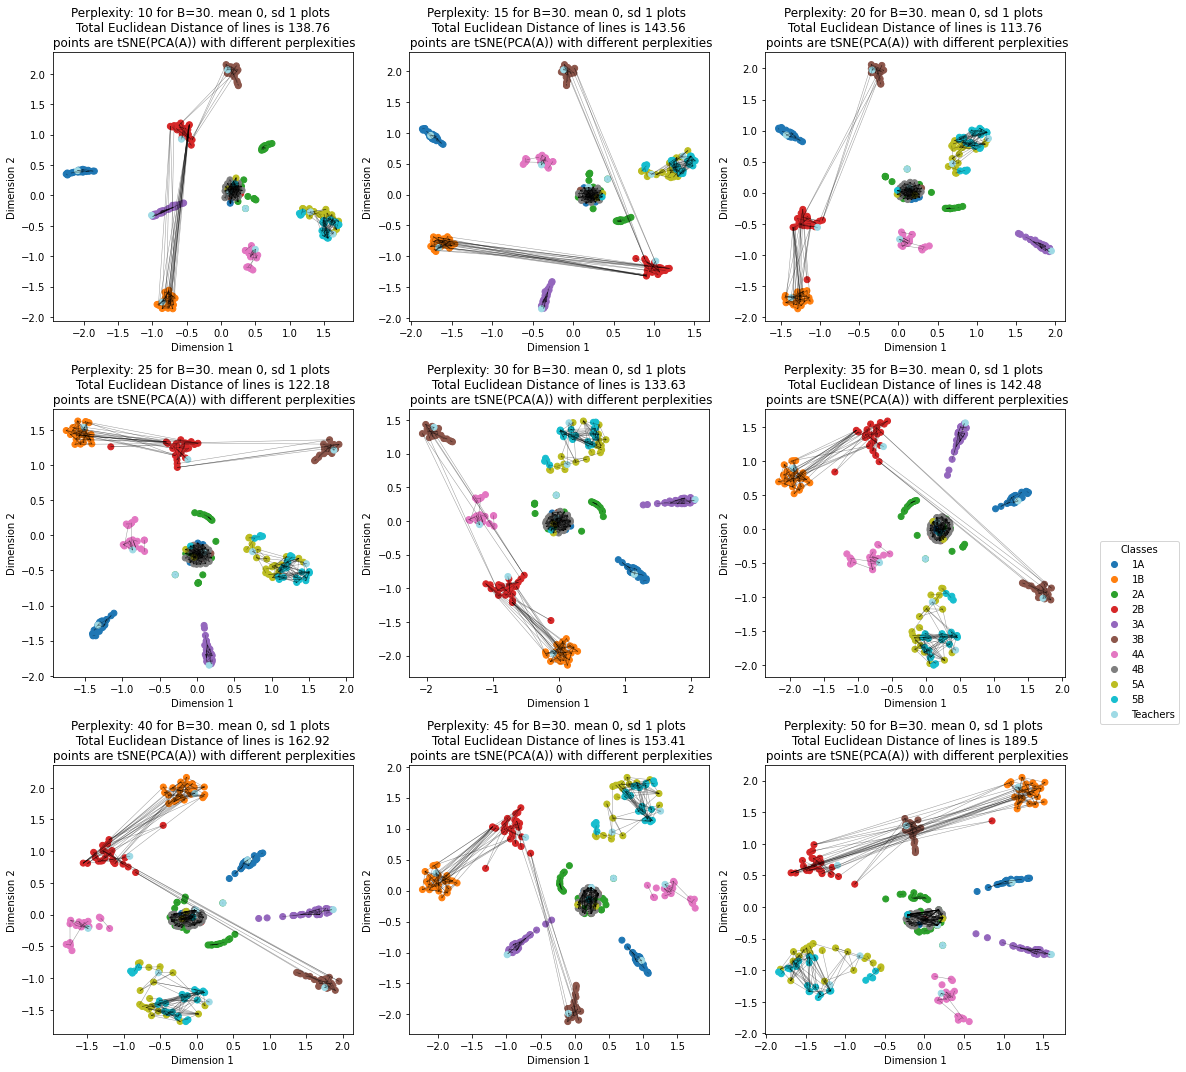

In [82]:
# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Embed Aobs (right embedding)
YA = single_spectral_Y(dense_adj, d=d)


# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the embedding of just the true adjacency matrix
    YA_tsne = tsne.fit_transform(YA)

    # Convert to DataFrame
    YA_tsne_df = pd.DataFrame(YA_tsne)
    YA_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(YA_tsne_df.shape[1])]
    YA_tsne_df["tau"] = np.tile(node_labels, 1)
    # standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
    scaler = StandardScaler()
    # Fit the scaler on the Dimension columns and transform them
    YA_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(YA_tsne_df[["Dimension_1", "Dimension_2"]])

    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(YA_tsne_df["Dimension_1"], YA_tsne_df["Dimension_2"], c=YA_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(YA_tsne_df)):
        for j in range(i + 1, len(YA_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([YA_tsne_df["Dimension_1"].iloc[i], YA_tsne_df["Dimension_1"].iloc[j]], 
                        [YA_tsne_df["Dimension_2"].iloc[i], YA_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)
    
    # title
    ax.set_title(f"Perplexity: {perp_val} for B={B}. mean 0, sd 1 plots \n Total Euclidean Distance of lines is {total_distance} \n points are tSNE(PCA(A)) with different perplexities")


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA1_tsne_perplexity_B20_plot_tsne(PCA(A))_sd1mean0.png", facecolor='white')

# Show the combined plot
plt.show()

In [83]:
# calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
total_distance = 0
for i in range(len(YA_tsne_df)):
    for j in range(i + 1, len(YA_tsne_df)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            total_distance += np.linalg.norm(YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

print(f"Total Euclidean distance covered by lines connecting nodes: {total_distance} for B={B}")


Total Euclidean distance covered by lines connecting nodes: 189.49585881037638 for B=30


### Fix perplexity and change B

100%|██████████| 50/50 [00:02<00:00, 24.72it/s]


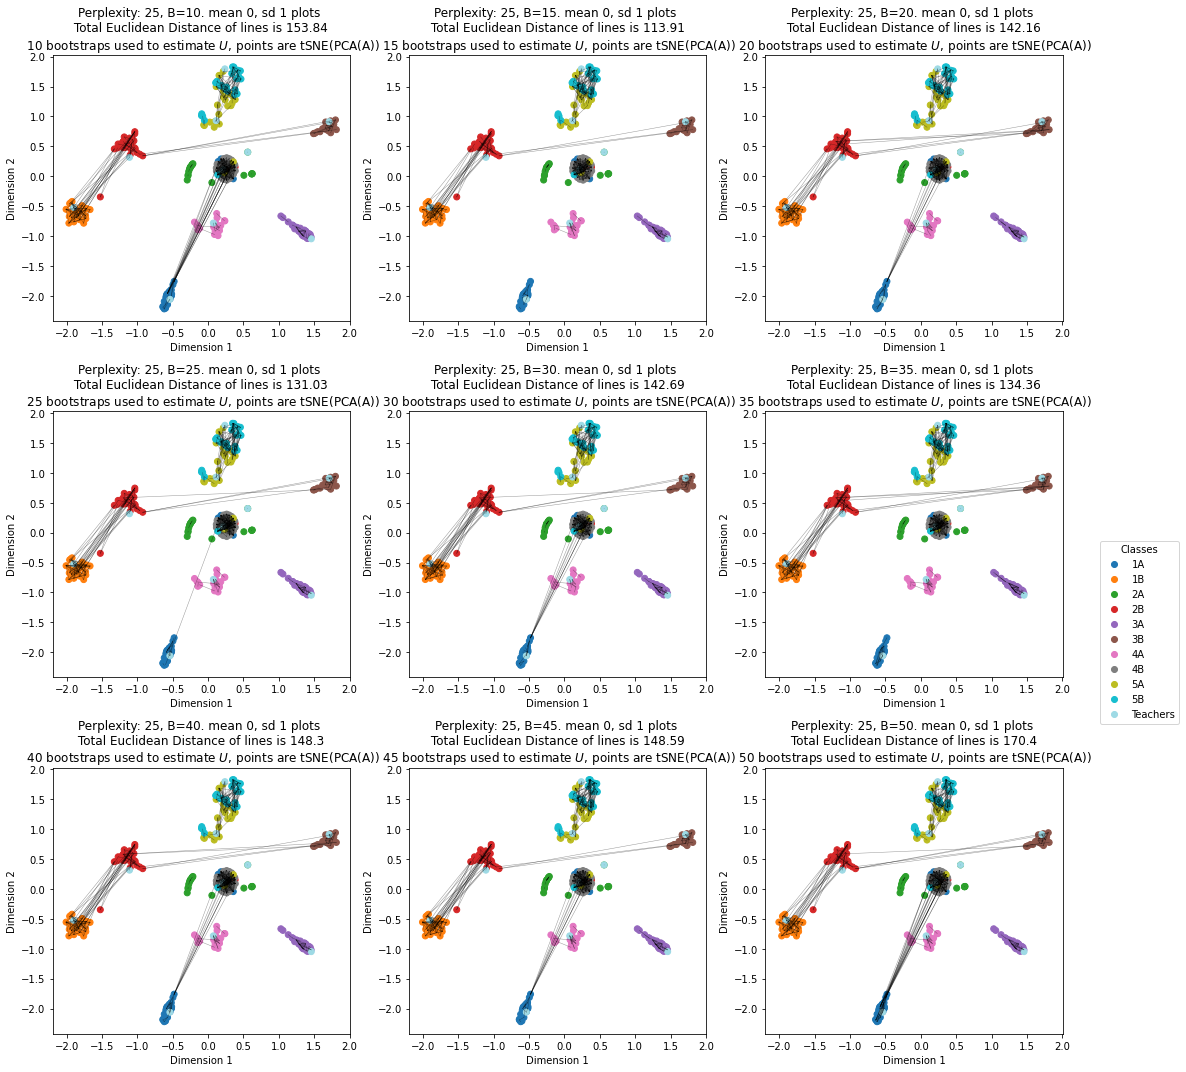

In [84]:
# Example setup for perplexity
perp_val = 25

# Embed Aobs (right embedding)
YA = single_spectral_Y(dense_adj, d=d)

tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
YA_tsne = tsne.fit_transform(YA)

# Convert to DataFrame
YA_tsne_df = pd.DataFrame(YA_tsne)
YA_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(YA_tsne_df.shape[1])]
YA_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
YA_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(YA_tsne_df[["Dimension_1", "Dimension_2"]])


# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(YA_tsne_df["Dimension_1"], YA_tsne_df["Dimension_2"], c=YA_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(YA_tsne_df)):
        for j in range(i + 1, len(YA_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([YA_tsne_df["Dimension_1"].iloc[i], YA_tsne_df["Dimension_1"].iloc[j]], 
                        [YA_tsne_df["Dimension_2"].iloc[i], YA_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - YA_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)
    
    # title
    ax.set_title(f"Perplexity: {perp_val}, B={B}. mean 0, sd 1 plots \n Total Euclidean Distance of lines is {total_distance} \n {B} bootstraps used to estimate $U$, points are tSNE(PCA(A))")  
    # Now this will correctly reflect B


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_A1_tsne_perp25_B_plot_tsne(PCA(A))_sd1mean0.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


## code from school_example_TSNEtuning_applyToA.ipynb

In [85]:
k = 2

100%|██████████| 20/20 [00:00<00:00, 28.76it/s]


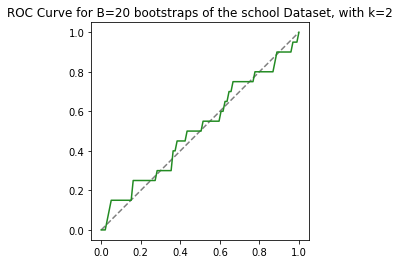

Total area (above and below y=x): 0.03318325072992964 for k=2


In [86]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 12

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [87]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [88]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Try different perplexity values in TSNE

Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``similarity matrix $U$''

<Axes: >

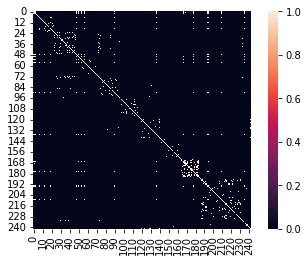

In [89]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
sns.heatmap(in_cov_friends_symm, square=True)

### Different perplexity values

B=20 fixed and the $U$ matrix already calculated from the UASE

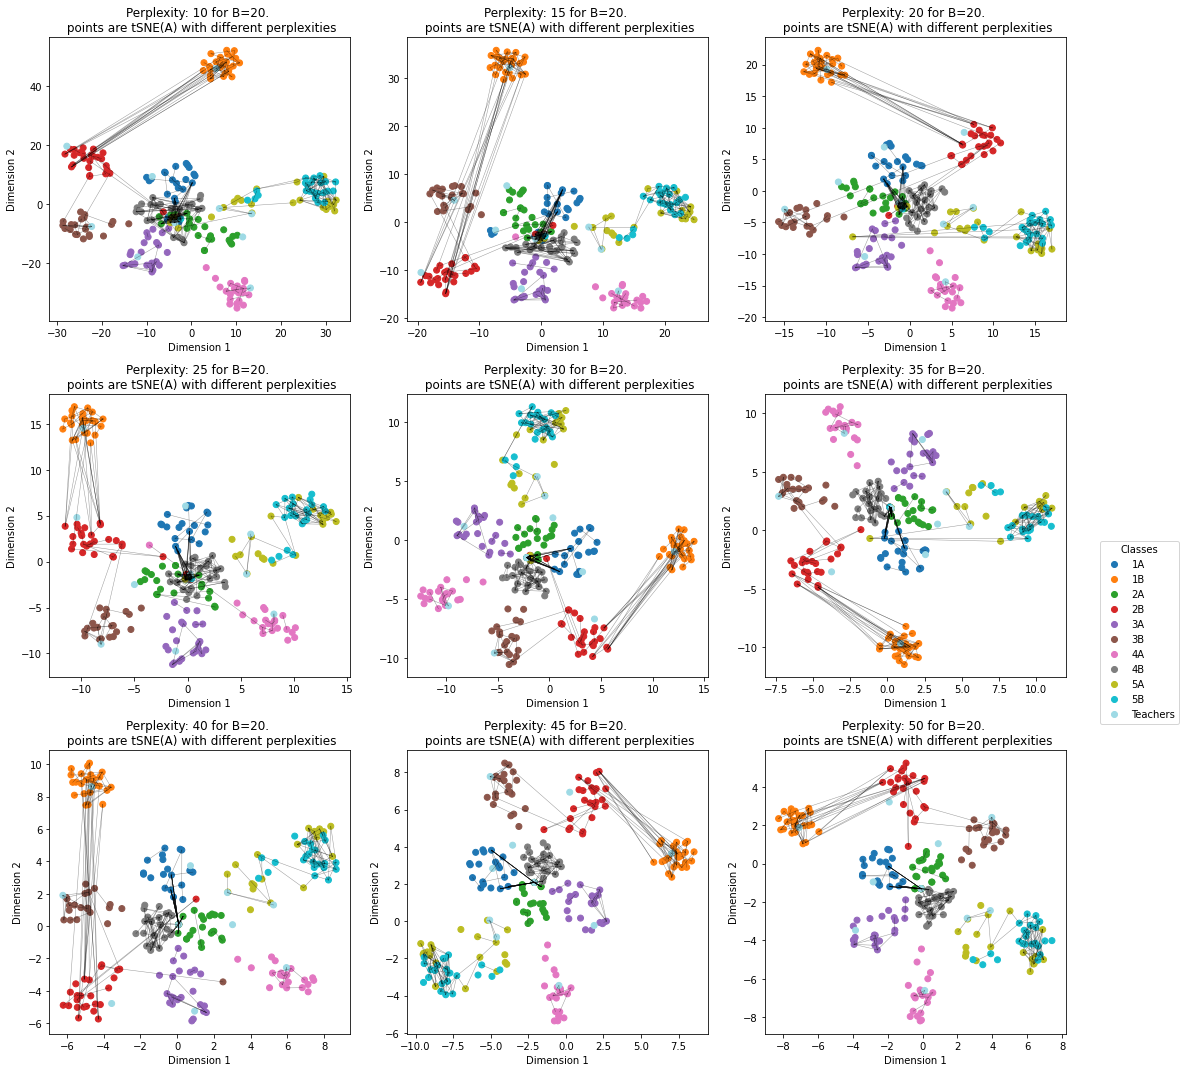

In [90]:
# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the true adjacency matrix
    A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val} for B={B}. \n points are tSNE(A) with different perplexities")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA0_tsne_perplexity_B20_plot_PCA(A).png", facecolor='white')

# Show the combined plot
plt.show()

### Fix perplexity and change B

100%|██████████| 50/50 [00:02<00:00, 22.51it/s]


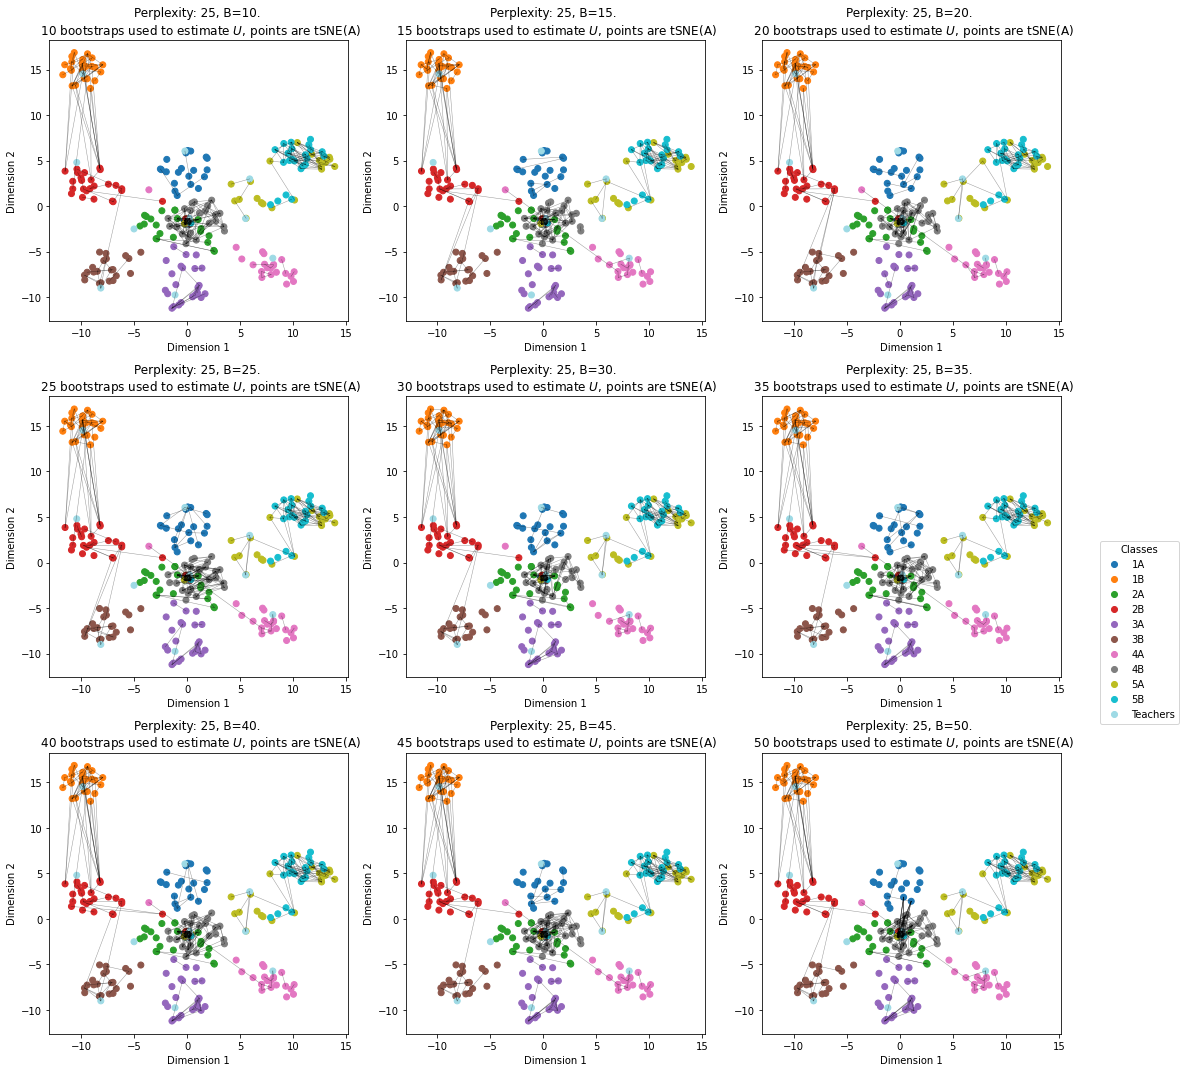

In [91]:
# Example setup for perplexity
perp_val = 25

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)


# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val}, B={B}. \n {B} bootstraps used to estimate $U$, points are tSNE(A)")  # Now this will correctly reflect B
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_A0_tsne_perp25_B_plot_tsne(A).png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


## Standardise so plots are mean 0, sd 1

In [92]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 12

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 20/20 [00:00<00:00, 27.18it/s]


In [93]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [95]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Try different perplexity values in TSNE

Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``similarity matrix $U$''

In [96]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

### Different perplexity values

B=20 fixed and the $U$ matrix already calculated from the UASE

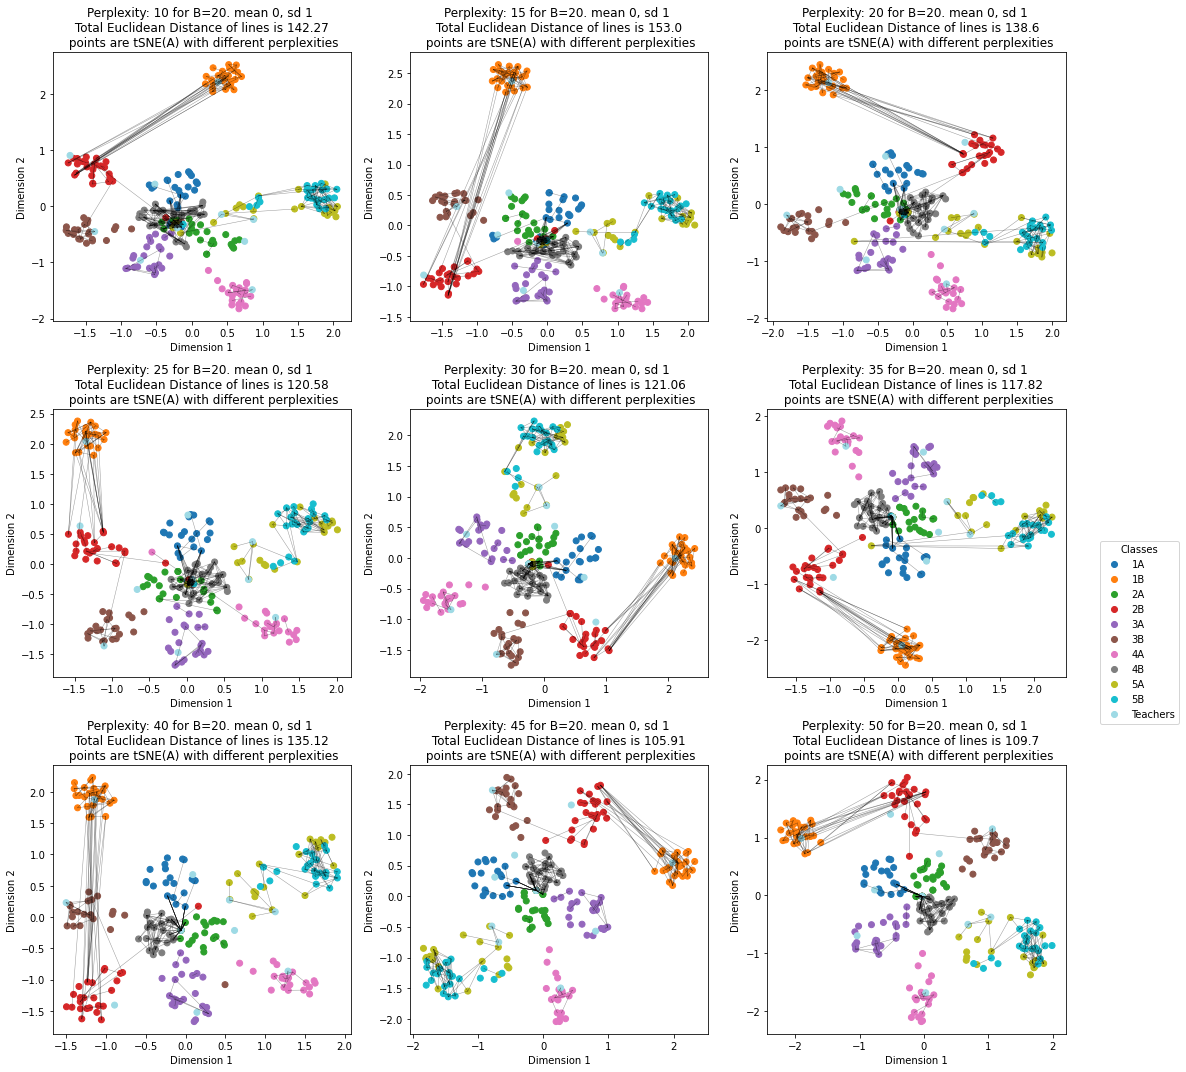

In [97]:
# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the true adjacency matrix
    A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
    scaler = StandardScaler()
    # Fit the scaler on the Dimension columns and transform them
    A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)
    
    # title
    ax.set_title(f"Perplexity: {perp_val} for B={B}. mean 0, sd 1 \n Total Euclidean Distance of lines is {total_distance} \n points are tSNE(A) with different perplexities")



# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA0_tsne_perplexity_B20_plot_PCA(A)_mean0sd1.png", facecolor='white')

# Show the combined plot
plt.show()

### Fix perplexity and change B

100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


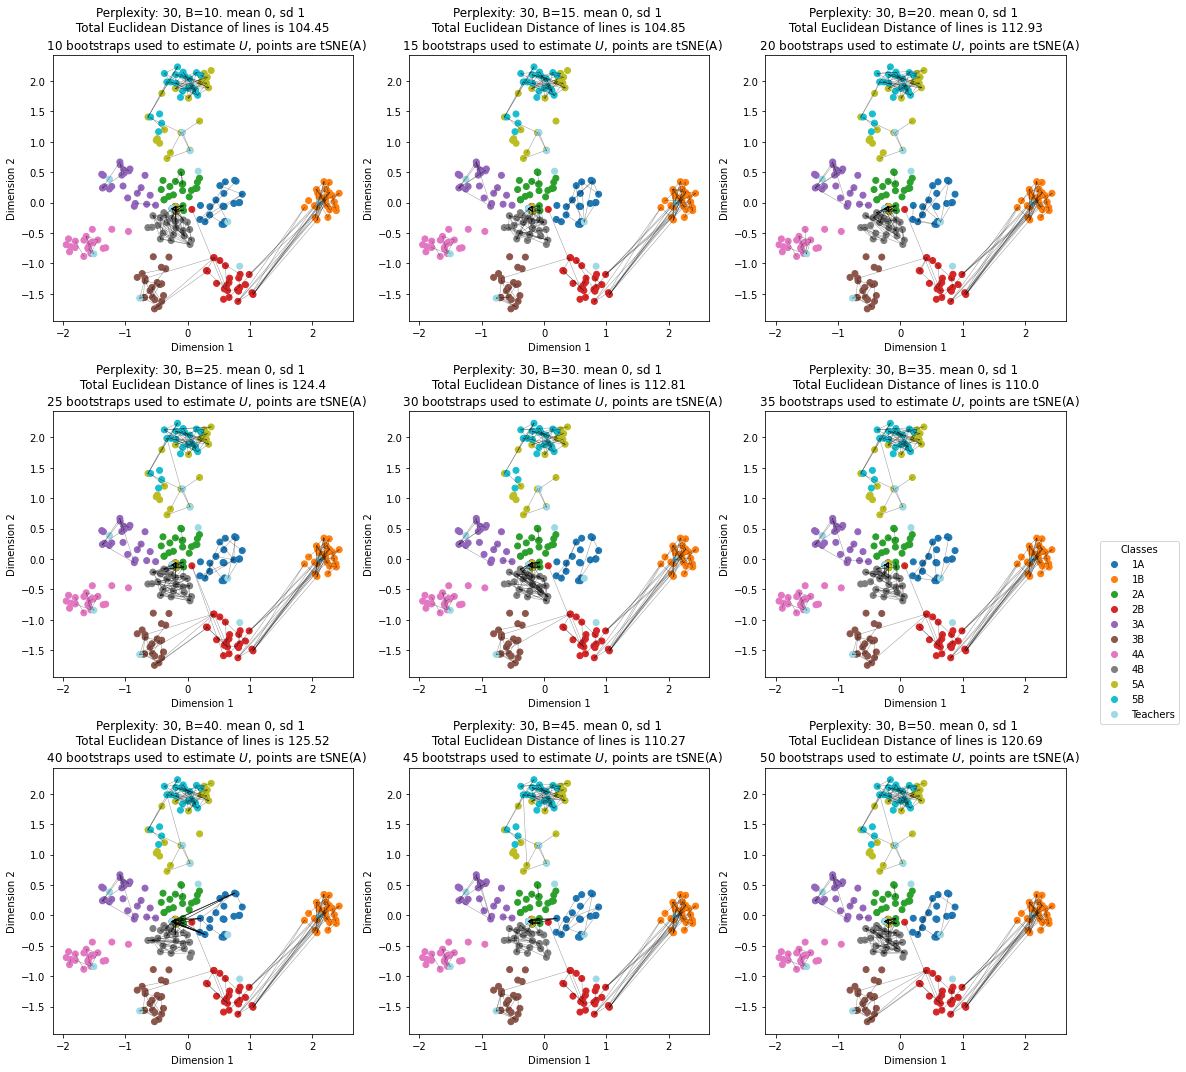

In [99]:
# Example setup for perplexity
perp_val = 30

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns
scaler = StandardScaler()
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])


# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20')
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    # AND calculate the total euclidean distance that the lines connecting the nodes in the tSNE plot cover
    total_distance = 0
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them
                # add this euclidean distance to the total_distance
                total_distance += np.linalg.norm(A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[i] - A_tsne_df[["Dimension_1", "Dimension_2"]].iloc[j])

    total_distance = round(total_distance, 2)

    # title
    ax.set_title(f"Perplexity: {perp_val}, B={B}. mean 0, sd 1 \n Total Euclidean Distance of lines is {total_distance} \n  {B} bootstraps used to estimate $U$, points are tSNE(A)")  
    # Now this will correctly reflect B


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_A0_tsne_perp25_B_plot_tsne(A)_mean0sd1.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()
